In [1]:
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
import json
import os,sys,datetime
import seaborn as sns

from tqdm import tqdm
from lightsim import single_sim

from multiprocessing import Pool

**Let's select the parameter space**

In [ ]:
# Resolution
res = 25

# Pruning parameters
beta = np.linspace(0.001, 5, res)

# Separation parameter
dist = np.linspace(0, 5, res)

# Set uncertainty on new observations
varc = 10

# Get dimensional d
d_norm = dist[:]/np.sqrt(varc)

# Set number of agents
N = 100

# Set number of repeat runs
rep = 5

# Where to store values
sv_pth = './b[' + str(beta[0]) + ',' + str(beta[-1]) + ']d[' + str(dist[0]) + ',' + str(dist[-1]) + ']/'

**Run simulations for $D_{KL}$**

In [ ]:
# Prepare multiprocessing

# Parameters
workers = os.cpu_count() - 6
csize = 6

# Initialize results
DV0 = np.empty((0, len(dist)))
DV0_var = DV0
DV = np.empty((0, len(dist)))
DV_var = DV

for b in tqdm(beta, desc= 'Be patient:', leave = False):
    
    # Create iterable function
    def it_single_sim(d : float):

        dv0 = np.empty((0))
        dv = np.empty((0))

        for i in range(0,rep):

            d0_, d_ = single_sim(N = N, beta = b, dist = d, var_c = varc)

            dv0 = np.concatenate((dv0, d0_[np.newaxis]))
            dv = np.concatenate((dv, d_[np.newaxis]))
        
        dv0_var = dv0.var()
        dv0 = dv0.mean()

        dv_var = dv.var()
        dv = dv.mean()

        return dv0, dv0_var, dv, dv_var
    
    # Initialize run results
    d0 = []
    v0 = []

    d = []
    v = []

    # Launch multiprocessing run
    if __name__=='__main__':
        with Pool(workers) as p:
            ps = p.map(it_single_sim, dist, chunksize = csize)

            for p in ps:

                d0.append(p[0])
                v0.append(p[1])

                d.append(p[2])
                v.append(p[3])

    # Assemble results
    DV0 = np.concatenate((DV0, np.asarray(d0)[np.newaxis, :]), axis = 0)
    DV0_var = np.concatenate((DV0_var, np.asarray(v0)[np.newaxis, :]), axis = 0)

    DV = np.concatenate((DV, np.asarray(d)[np.newaxis, :]), axis = 0)
    DV_var = np.concatenate((DV_var, np.asarray(v)[np.newaxis, :]), axis = 0)

# Save results to local
os.makedirs(sv_pth, exist_ok = True)
np.save(sv_pth + str(res) + 'DV0.npy', DV0)
np.save(sv_pth + str(res) + 'DV0_var.npy', DV0_var)
np.save(sv_pth + str(res) + 'DV.npy', DV)
np.save(sv_pth + str(res) + 'DV_var.npy', DV_var)

Please kill me:  60%|██████    | 24/40 [41:45<25:39, 96.21s/it]  Aug 06, 2025 7:56:25 PM java.util.prefs.FileSystemPreferences syncWorld


In [5]:
# Get labels for graphics
b_st = []
for b in beta:

    b_st.append(f'{b: 0,.1f}')

d_st = []
for dis in dist:

    d_st.append(f'{dis: 0,.1f}')

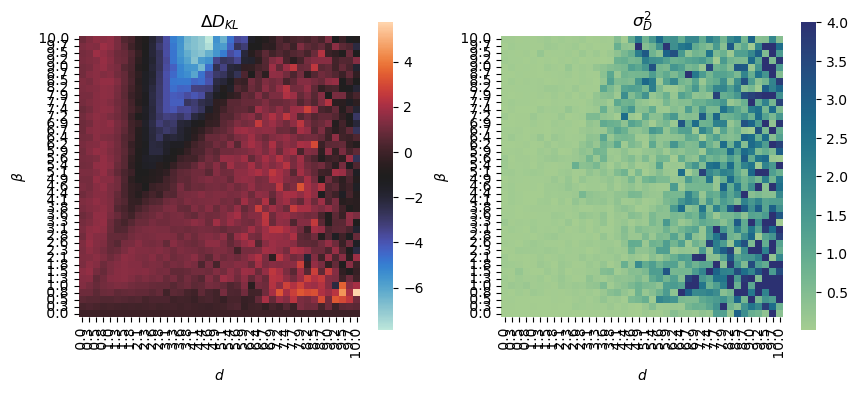

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

sns.heatmap(DV-DV0, square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[0])
sns.heatmap(DV_var, vmax = 4, square = True, cmap = 'crest', xticklabels = d_st, yticklabels = b_st, ax = ax[1])

ax[0].set_title('$\\Delta D_{KL}$')
ax[1].set_title('$\\sigma^{2}_{D}$')

for a in ax:

    a.invert_yaxis()
    #a.invert_xaxis()

    a.set_xlabel('$d$')
    a.set_ylabel('$\\beta$')

#plt.savefig('aaa.png', dpi = 300)